In [9]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit import BasicAer
from qiskit.visualization import plot_histogram, plot_bloch_multivector

 - This QRAM has 2 address qubits and 4 memory cells with 3 bit capacity each, storing 1,3,4,5
 - Seemingly this is the largest possible QRAM

In [11]:
def QRAM(no_of_address_qubits,no_of_bits_in_memory_cell):
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    #bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
    #bus_noa = mc
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(mc, "bus")
    #cr = ClassicalRegister(bus_noa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus)
    
    ## adjust the address here

    qc.h(qr_a)
    
    #1 stored in 0th memory cell
    qc.x(qr_m[0])
    
    #3 stored in 1st memory cell
    qc.x(qr_m[3])
    qc.x(qr_m[4])
    
    #4 stored in 2nd memory cell
    qc.x(qr_m[8])
    
    #5 stored in 3rd memory cell
    qc.x(qr_m[9])
    qc.x(qr_m[11])

    
### here we will start with the branching
    # there is X gate at the second qubit first
    
    qc.x(qr_r[1])
    # the first branching 
    qc.cx(qr_a[0],qr_r[0])
    qc.cx(qr_r[0],qr_r[1])
    
    # further branchings 
    if a==1:
        ### measuring using measure one
        qc = qc.compose(meas_QRAM_order(a))

        ## finally measuring the bus
        for i in range(0,a):
            qc.measure(qr_a[i],cr[i])
        qc.measure(qr_bus, cr[a])
        return qc
    else:
        # no. of address bits = no. of rouitng iterations
        for i in range(2,a+1):
            for j in range(0,2**(i - 1)):
                qc.ccx(qr_a[i-1], qr_r[j], qr_r[j + 2**(i-1)])
                qc.cx(  qr_r[j + 2**(i-1)], qr_r[j])
            #qc.barrier()

### measuring using measure one
    qc = qc.compose(meas_QRAM_best(a,mc))

## finally measuring the bus
#     for i in range(0,a):
#         #qc.measure(qr_a[i],cr[i])
#         qc.measure(qr_bus[i], cr[a+i])
#     qc.measure(qr_bus[2],cr[4])

    #qc.measure(qr_bus,cr)
    
    return qc

QRAM is treated as the initial state preparation operator A in the Grover operator

$$Q = -A S_0 A^{\dagger} S_f$$

In [2]:
def QRM(no_of_address_qubits,no_of_bits_in_memory_cell):
    
    
    qc = QRAM(no_of_address_qubits,no_of_bits_in_memory_cell)
    qram = qc.to_gate()
    qram.name = 'QRAM'
    return qram
    
    

QRAM dagger

In [3]:
def QRAMi(no_of_address_qubits,no_of_bits_in_memory_cell):
    
    qc = QRAM(no_of_address_qubits,no_of_bits_in_memory_cell)
    qci = qc.to_gate()
    qrami = qci.inverse()
    qrami.name = 'QRAMi'
    return qrami

Diffuser

In [37]:
def S_0():
    
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
    bus_noa = mc
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_b = QuantumRegister(mc, "bus")
    cr = ClassicalRegister(bus_noa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus, cr)
    
    
    ctr = []
    for j in range(a):
        ctr.append(j)
    for k in range(a+m+r,a+m+r+mc-1):
        ctr.append(k)
        
#    qc.barrier()

    qc.x(qr_a)
    qc.x(qr_b)
    qc.h(qr_b[mc-1])
    qc.mct(ctr,qr_b[mc-1])
    qc.h(qr_b[mc-1])
    qc.x(qr_a)
    qc.x(qr_b)

#    qc.barrier()
    return qc

Oracle to amplify 4 out of 1,3,4,5

In [38]:
def Oracle(): #to amplify 4 particularly
    
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
    bus_noa = mc
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(mc, "bus")
    cr = ClassicalRegister(bus_noa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus, cr)
    
    qc.x(qr_bus[0])
    qc.x(qr_bus[1])
    qc.h(qr_bus[mc-1])
    qc.ccx(qr_bus[0],qr_bus[1],qr_bus[mc-1])
    qc.h(qr_bus[mc-1])
    qc.x(qr_bus[0])
    qc.x(qr_bus[1])
    
    return qc

In [33]:
def meas_QRAM_best(no_of_address_qubits,no_of_bits_in_memory_cell):
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
    bus_noa = mc
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(mc, "bus")
    #cr = ClassicalRegister(bus_noa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus)

    div = np.array([1,0])
    new_div = ["" for x in range(2**a)]

        
    for i in range(0,a-1): # here i controls the number of times this loop runs, each time we move one level ahead
        div = np.append(div,div)
        dim = len(div)
        for j in range(0,int(dim/2)):
            new_div[j] = numConcat(0,div[j])
        for j in range(int(dim/2),int(dim)):
            new_div[j] = numConcat(1,div[j])
        div = new_div[0:dim]
    
    # for the case of a = 1
    if a == 1:
        new_div = np.array([1,0])
        
        
    # as the original function uses strings we will need to convert shit to integers
    for i in range(0,len(new_div)):
            div[i] = int(new_div[i])
        

        
    # cnverting the array to decimal
    div_decimal = np.zeros(len(div))
    for i in range(0, len(div)):
        div_decimal[i]  = int(binaryToDecimal(div[i])) 
## here is the quantum circuit part of things which do the job



    ## the ordering in which we measure will be same just that it will have to be repeated a couole of times
    ## 1,0,3,2 to 1,1,0,0,3,3,2,2 for case of two 
    final_ord_mat = np.zeros([mc,len(div_decimal)])
    for i in range(len(div_decimal)):
        add = 0
        for j in range(mc):
            final_ord_mat[j,i] = int(div_decimal[i])*int(mc)
            final_ord_mat[j,i] += add
            add = add + 1
    ## now this matrix has to be concatinated onto one another
    final_ord = np.reshape(final_ord_mat,(int(final_ord_mat.size),1), order='F')
    
    
    
    ## now we will also need to input address orderings 
    add_ord = np.zeros(mc*len(div_decimal))
    j_last = 0    
    for i in range(0, len(div_decimal)):
         # the purpose of j_last is is to start from where the last loop stopped in i+j terms
        for j in range( j_last, j_last + mc):
            add_ord[i+j] = i
            j_last = j
            
    ## this one is here for bus orderings 
    bus_ord = np.zeros(0)
    one_ord = range(0, mc)
    for i in range(0,r):
        bus_ord = np.append(bus_ord,one_ord)
            

            
    ## finally adding the ccx gates which will copy out whatever is in the memory cells to the Bus
    for i in range(0, m ):
        qc.ccx(qr_r[int(add_ord[i])], qr_m[int(final_ord[i])], qr_bus[int(bus_ord[i])])
  
    return qc


In [34]:
## to functions that we will be using for concatination of "0" and "1" in front the numbers and the other one for addition for the conversion of the binary to decimal 
def binaryToDecimal(binary):
     
    binary1 = binary
    decimal, i, n = 0, 0, 0
    while(binary != 0):
        dec = binary % 10
        decimal = decimal + dec * pow(2, i)
        binary = binary//10
        i += 1
    return decimal 
    
def numConcat(num1, num2): # this should actually do all the additions in the form of strings and then when you finally
                           # take out whatever is stored in the matrix then you should actually convert that to int
  
     # find number of digits in num2
    digits = len(str(num2))
    num2 = str(num2)
    num1 = str(num1)
  
     # add zeroes to the end of num1
#     num1 = num1 * (10**digits)
  
     # add num2 to num1
    num1 += num2
  
    return num1

In [55]:
qc = QRAM(2,3)

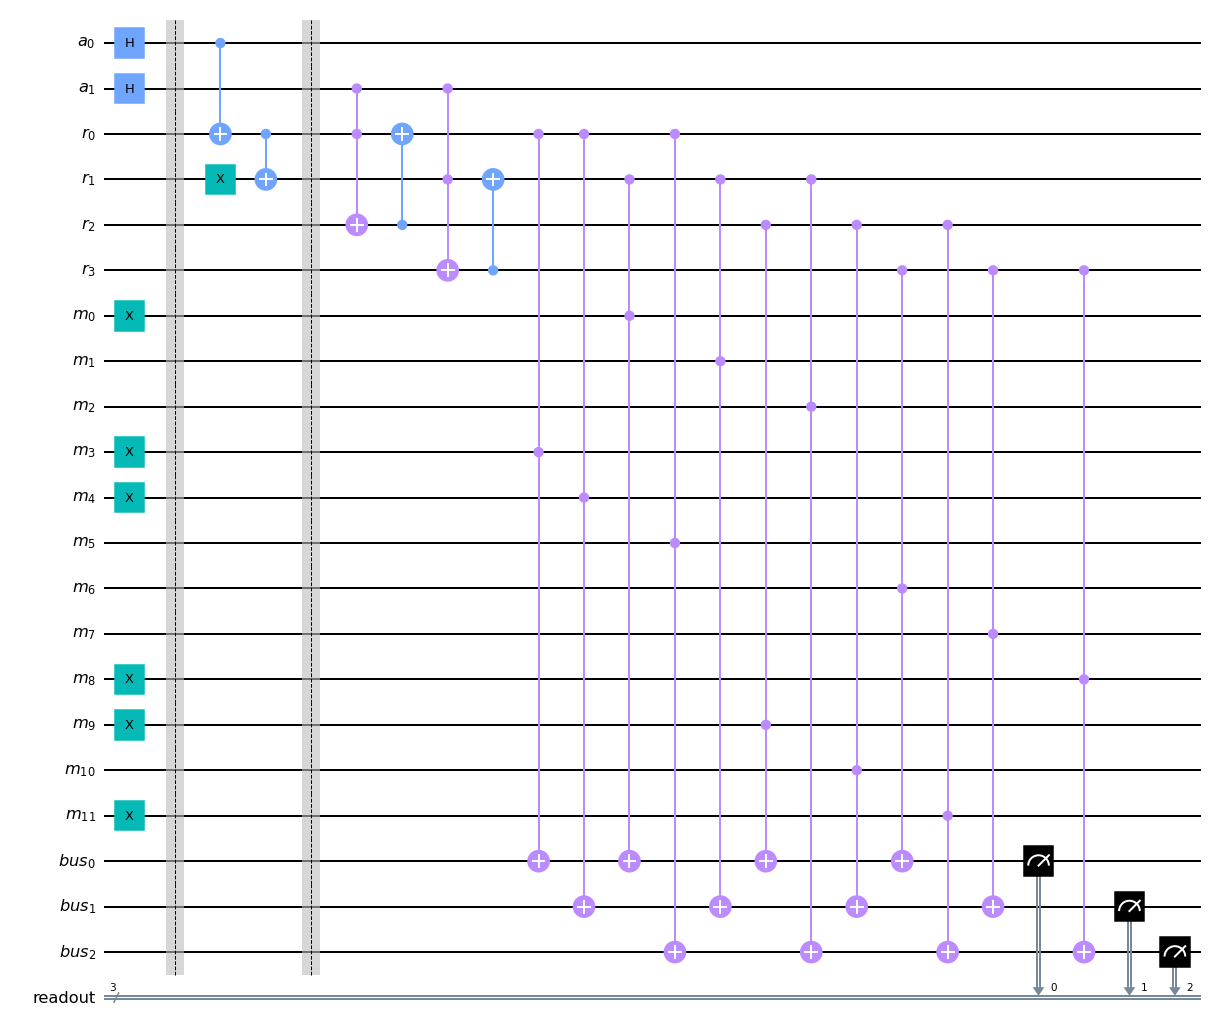

In [56]:
qc.draw('mpl')

### Before Amplification

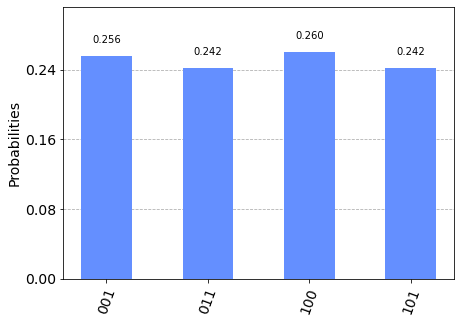

In [57]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc,backend)
counts = job.result().get_counts()
plot_histogram(counts)

### QAA applied on the QRAM

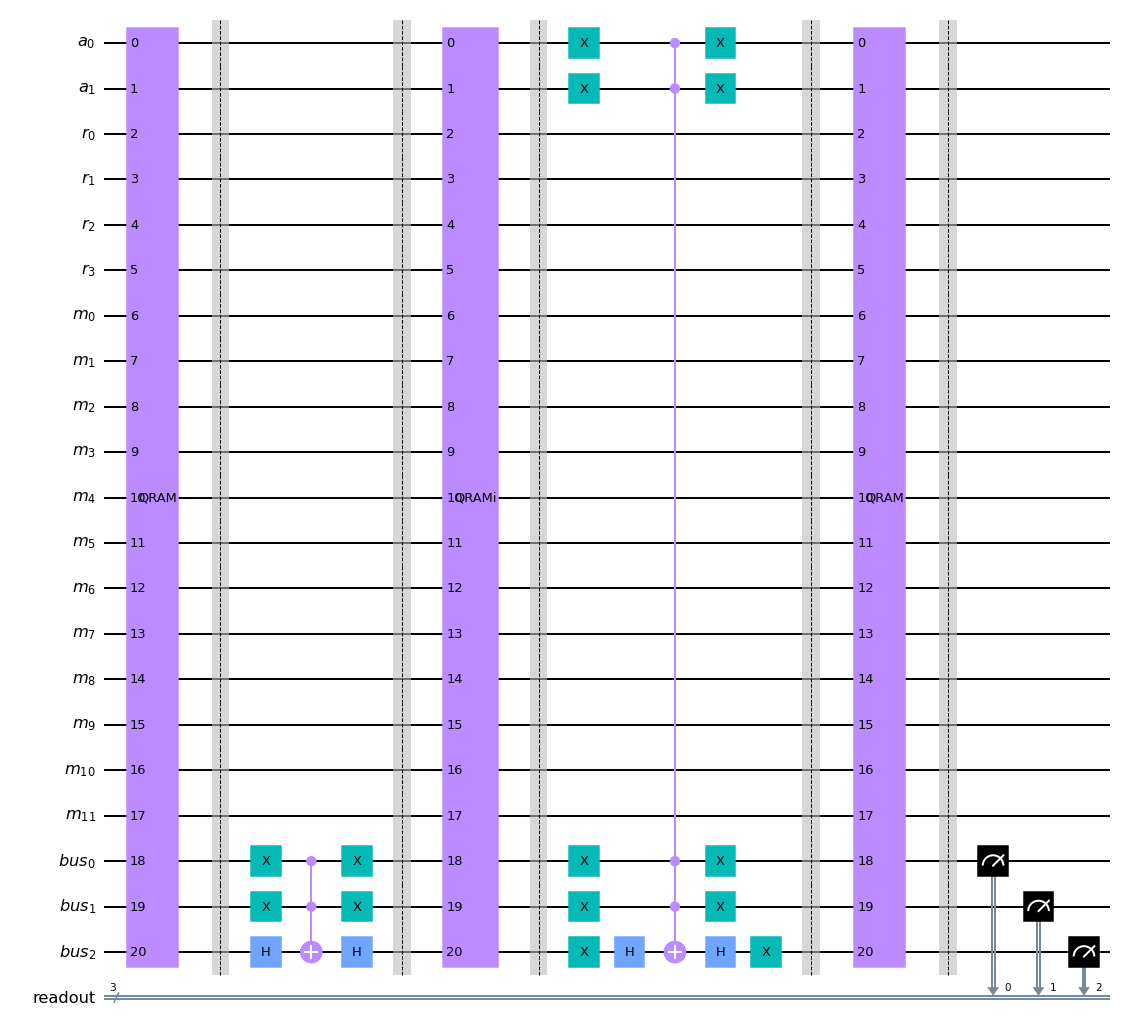

In [39]:
no_of_bits_in_memory_cell = 3
no_of_address_qubits = 2

mc = no_of_bits_in_memory_cell
a = no_of_address_qubits
r = 2**a # no.of routing qubits
m = (2**a)*mc # no. of memory qubits
bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
bus_noa = mc
    
qr_a = QuantumRegister(a, "a")
qr_r = QuantumRegister(r, "r")
qr_m  = QuantumRegister(m,  "m")
qr_bus = QuantumRegister(mc, "bus")
cr = ClassicalRegister(bus_noa, "readout")
    
qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus, cr)

qc = qc.compose(QRM(no_of_address_qubits,no_of_bits_in_memory_cell))
qc.barrier()

reps = 1

for rep in range(reps):
    qc = qc.compose(Oracle())
    qc.barrier()
    qc = qc.compose(QRAMi(no_of_address_qubits,no_of_bits_in_memory_cell))
    qc.barrier()
    qc = qc.compose(S_0())
    qc.barrier()
    qc = qc.compose(QRM(no_of_address_qubits,no_of_bits_in_memory_cell))
    qc.barrier()

# for i in range(0,a):
#     qc.measure(qr_a[i],cr[i])
    
qc.measure(qr_bus, cr)

qc.draw('mpl')

### After QAA

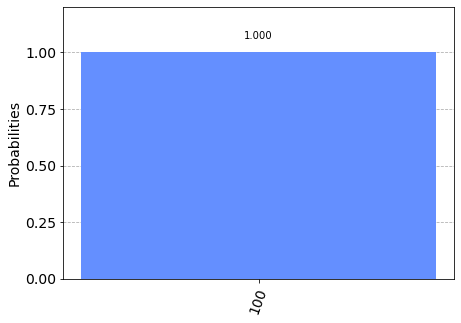

In [40]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc,backend)
counts = job.result().get_counts()
plot_histogram(counts)

### Amplifying 3 out of 1,3,4,5

In [47]:
def Oracle2(): #to amplify 3 particularly
    
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
    bus_noa = mc
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(mc, "bus")
    cr = ClassicalRegister(bus_noa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus, cr)
    
    qc.x(qr_bus[mc-1])
    #qc.x(qr_bus[1])
    qc.h(qr_bus[0])
    qc.ccx(qr_bus[2],qr_bus[1],qr_bus[0])
    qc.h(qr_bus[0])
    #qc.x(qr_bus[0])
    qc.x(qr_bus[mc-1])
    
    return qc

In [48]:
no_of_bits_in_memory_cell = 3
no_of_address_qubits = 2

mc = no_of_bits_in_memory_cell
a = no_of_address_qubits
r = 2**a # no.of routing qubits
m = (2**a)*mc # no. of memory qubits
bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
bus_noa = mc
    
qr_a = QuantumRegister(a, "a")
qr_r = QuantumRegister(r, "r")
qr_m  = QuantumRegister(m,  "m")
qr_bus = QuantumRegister(mc, "bus")
cr = ClassicalRegister(bus_noa, "readout")
    
qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus, cr)

qc = qc.compose(QRM(no_of_address_qubits,no_of_bits_in_memory_cell))
qc.barrier()

reps = 1

for rep in range(reps):
    qc = qc.compose(Oracle2())
    qc.barrier()
    qc = qc.compose(QRAMi(no_of_address_qubits,no_of_bits_in_memory_cell))
    qc.barrier()
    qc = qc.compose(S_0())
    qc.barrier()
    qc = qc.compose(QRM(no_of_address_qubits,no_of_bits_in_memory_cell))
    qc.barrier()

# for i in range(0,a):
#     qc.measure(qr_a[i],cr[i])
    
qc.measure(qr_bus, cr)

#qc.draw('mpl')

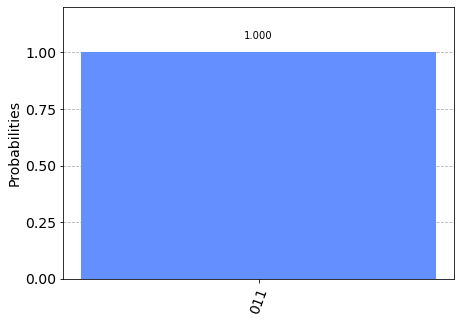

In [49]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc,backend)
counts = job.result().get_counts()
plot_histogram(counts)

### Amplifying even out of 1,3,4,5

In [50]:
def Oracle3(): #to amplify 3 particularly
    
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
    bus_noa = mc
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(mc, "bus")
    cr = ClassicalRegister(bus_noa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus, cr)
    
    qc.x(qr_bus[0])
    qc.z(qr_bus[0])
    qc.x(qr_bus[0])
    
    return qc

In [53]:
no_of_bits_in_memory_cell = 3
no_of_address_qubits = 2

mc = no_of_bits_in_memory_cell
a = no_of_address_qubits
r = 2**a # no.of routing qubits
m = (2**a)*mc # no. of memory qubits
bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
bus_noa = mc
    
qr_a = QuantumRegister(a, "a")
qr_r = QuantumRegister(r, "r")
qr_m  = QuantumRegister(m,  "m")
qr_bus = QuantumRegister(mc, "bus")
cr = ClassicalRegister(bus_noa, "readout")
    
qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus, cr)

qc = qc.compose(QRM(no_of_address_qubits,no_of_bits_in_memory_cell))
qc.barrier()

reps = 1

for rep in range(reps):
    qc = qc.compose(Oracle3())
    qc.barrier()
    qc = qc.compose(QRAMi(no_of_address_qubits,no_of_bits_in_memory_cell))
    qc.barrier()
    qc = qc.compose(S_0())
    qc.barrier()
    qc = qc.compose(QRM(no_of_address_qubits,no_of_bits_in_memory_cell))
    qc.barrier()

# for i in range(0,a):
#     qc.measure(qr_a[i],cr[i])
    
qc.measure(qr_bus, cr)

#qc.draw('mpl')

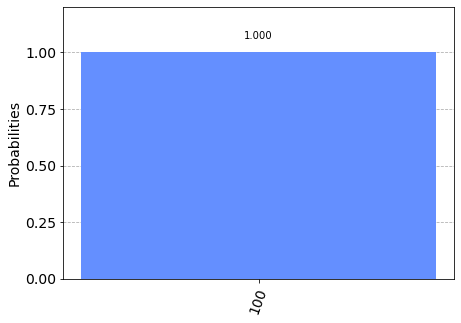

In [54]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc,backend)
counts = job.result().get_counts()
plot_histogram(counts)

### Bigger QRAM

If we make a QRAM with 3 address qubits, it exceeds the simulator limit which is 24, so QRAM with only 2 address qubits can be made, which will have total 21 qubits and 3 classical bits (if we use memory cells with 3 bit capacity each)

In [55]:
def QRAM(no_of_address_qubits,no_of_bits_in_memory_cell):
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    #bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
    #bus_noa = mc
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(mc, "bus")
    #cr = ClassicalRegister(bus_noa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus)
    
    ## adjust the address here

    qc.h(qr_a)
    
    #1 stored in 0th memory cell
    qc.x(qr_m[0])
    
    #3 stored in 1st memory cell
    qc.x(qr_m[3])
    qc.x(qr_m[4])
    
    #4 stored in 2nd memory cell
    qc.x(qr_m[8])
    
    #5 stored in 3rd memory cell
    qc.x(qr_m[9])
    qc.x(qr_m[11])
    
    #7 stored in 4rd memory cell
    qc.x(qr_m[12])
    qc.x(qr_m[13])
    qc.x(qr_m[14])

    
### here we will start with the branching
    # there is X gate at the second qubit first
    
    qc.x(qr_r[1])
    # the first branching 
    qc.cx(qr_a[0],qr_r[0])
    qc.cx(qr_r[0],qr_r[1])
    
    # further branchings 
    if a==1:
        ### measuring using measure one
        qc = qc.compose(meas_QRAM_order(a))

        ## finally measuring the bus
        for i in range(0,a):
            qc.measure(qr_a[i],cr[i])
        qc.measure(qr_bus, cr[a])
        return qc
    else:
        # no. of address bits = no. of rouitng iterations
        for i in range(2,a+1):
            for j in range(0,2**(i - 1)):
                qc.ccx(qr_a[i-1], qr_r[j], qr_r[j + 2**(i-1)])
                qc.cx(  qr_r[j + 2**(i-1)], qr_r[j])
            #qc.barrier()

### measuring using measure one
    qc = qc.compose(meas_QRAM_best(a,mc))

## finally measuring the bus
#     for i in range(0,a):
#         #qc.measure(qr_a[i],cr[i])
#         qc.measure(qr_bus[i], cr[a+i])
#     qc.measure(qr_bus[2],cr[4])

    #qc.measure(qr_bus,cr)
    
    return qc

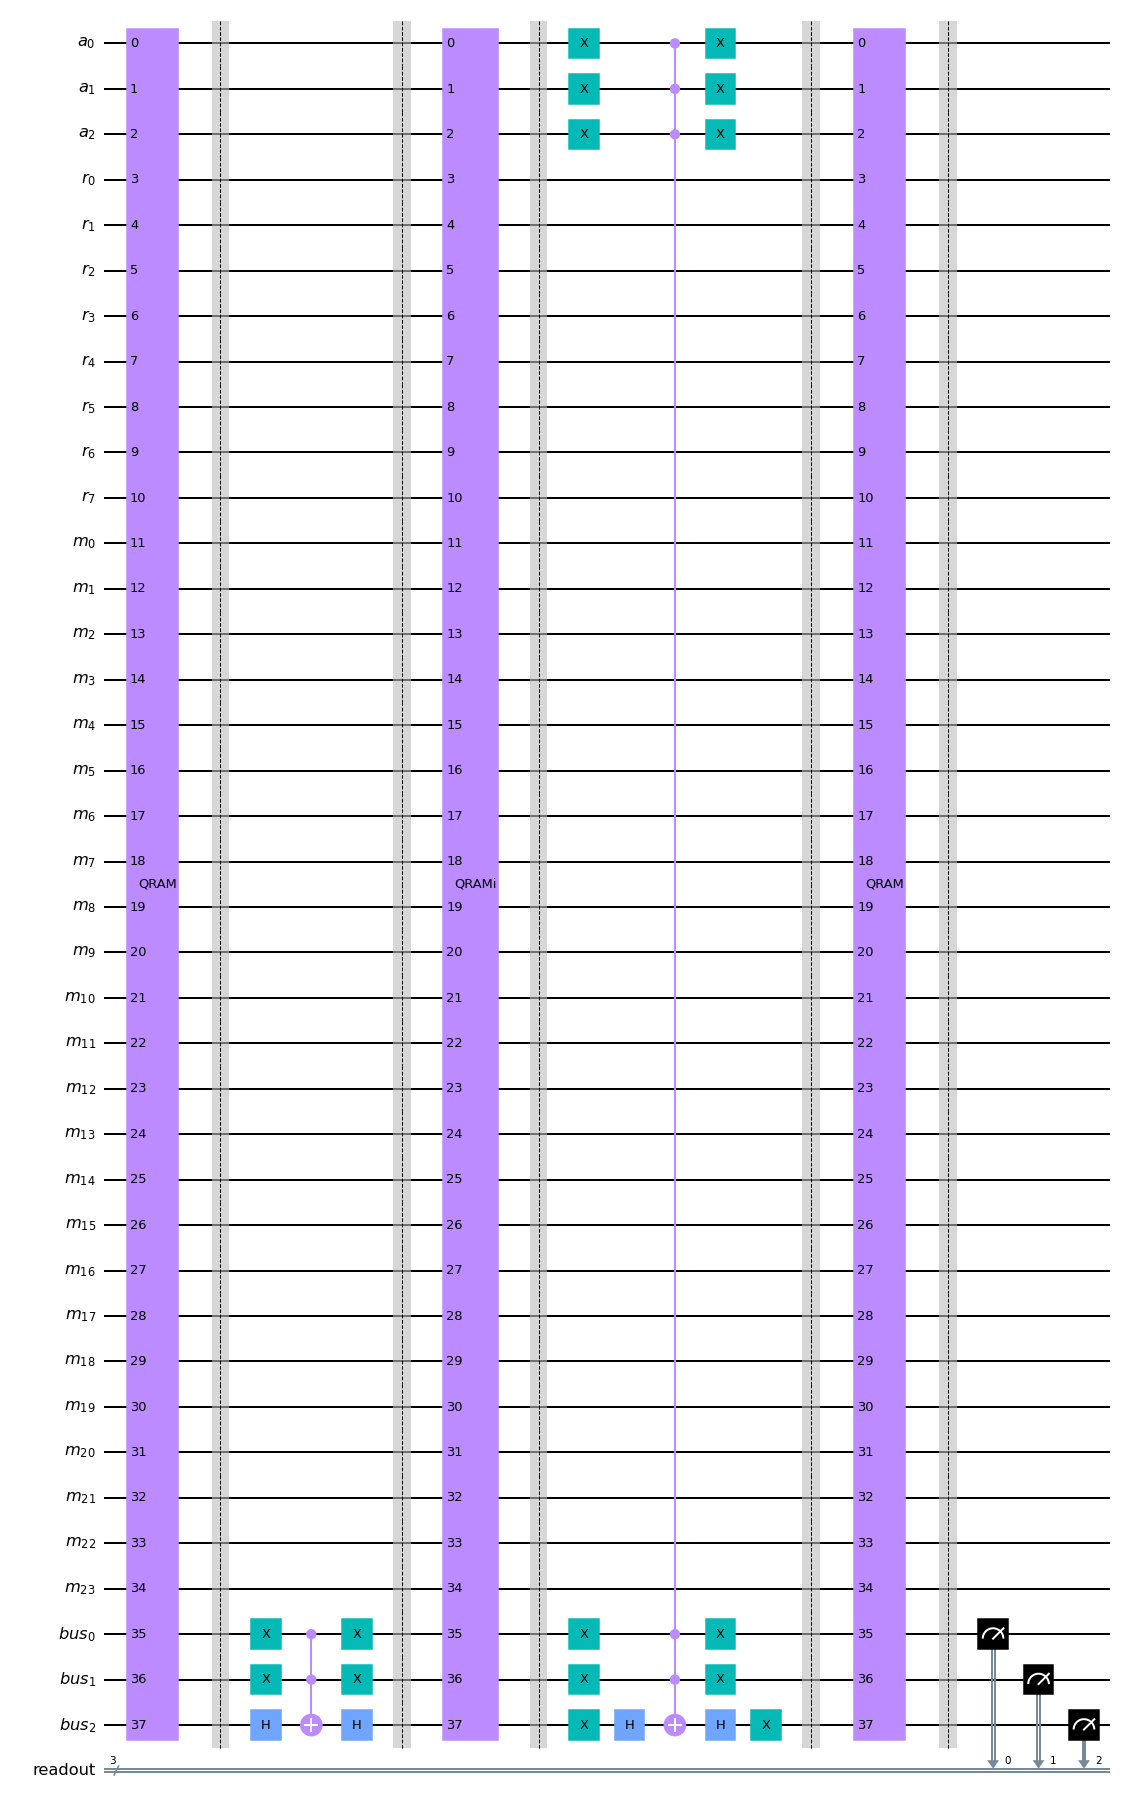

In [57]:
no_of_bits_in_memory_cell = 3
no_of_address_qubits = 3

mc = no_of_bits_in_memory_cell
a = no_of_address_qubits
r = 2**a # no.of routing qubits
m = (2**a)*mc # no. of memory qubits
bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
bus_noa = mc
    
qr_a = QuantumRegister(a, "a")
qr_r = QuantumRegister(r, "r")
qr_m  = QuantumRegister(m,  "m")
qr_bus = QuantumRegister(mc, "bus")
cr = ClassicalRegister(bus_noa, "readout")
    
qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus, cr)

qc = qc.compose(QRM(no_of_address_qubits,no_of_bits_in_memory_cell))
qc.barrier()

reps = 1

for rep in range(reps):
    qc = qc.compose(Oracle())
    qc.barrier()
    qc = qc.compose(QRAMi(no_of_address_qubits,no_of_bits_in_memory_cell))
    qc.barrier()
    qc = qc.compose(S_0())
    qc.barrier()
    qc = qc.compose(QRM(no_of_address_qubits,no_of_bits_in_memory_cell))
    qc.barrier()

# for i in range(0,a):
#     qc.measure(qr_a[i],cr[i])
    
qc.measure(qr_bus, cr)

qc.draw('mpl')

In [58]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc,backend)
counts = job.result().get_counts()
plot_histogram(counts)

BasicAerError: 'Number of qubits 38 is greater than maximum (24) for "qasm_simulator".'